# Исследование данных о продажах игр

Цель исследования - подготовка рекомендаций для разработки стратегии на 2017 год для интернет-магазина «Стримчик», осуществляющего продажи компьютерных игр по всему миру. 

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation) до 2016 года. Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Также необходимо проверить гипотезы:
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
2. Средние пользовательские рейтинги жанров Action и Sports разные.

**Определения и сокращения:**

ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

In [1]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st


warnings.filterwarnings('ignore')

## Исходные данные 

In [2]:
data = pd.read_csv("https://code.s3.yandex.net/datasets/games.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [3]:
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


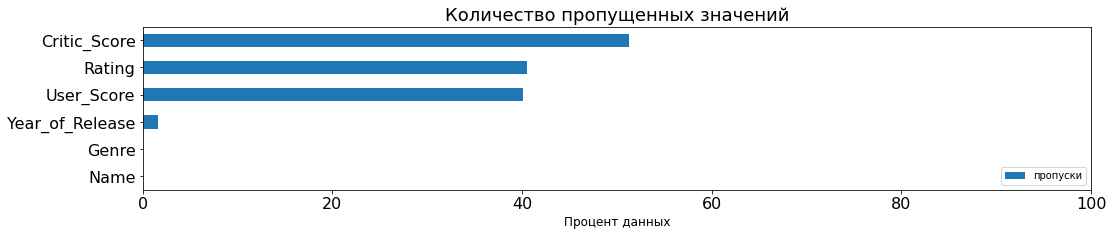

                 пропуски
Critic_Score         8578
Rating               6766
User_Score           6701
Year_of_Release       269
Name                    2
Genre                   2


In [4]:
def show_nan(df: pd.DataFrame, title: str = "Количество пропущенных значений"):
    (
        (df.isna().mean().to_frame()
        .rename(columns={0: "пропуски"}) * 100)
        .query("пропуски > 0").sort_values("пропуски", ascending=True)
    ).plot(kind="barh", figsize=(17, 3), fontsize=16, xlim=(0, 100))
    plt.title(title , size=18)
    plt.legend(loc="lower right")
    plt.xlabel("Процент данных", size=12)
    plt.show()
    print(
        df.isna().sum().to_frame()
        .rename(columns={0: "пропуски"}).query("пропуски > 0")
        .sort_values("пропуски", ascending=False)
    )

show_nan(data)

### Промежуточные выводы

Получены исходные данные:
1. общее количество строк вы выборке составляет - 16715;
2. имеются пропуски в данных по 6 полям: 
    - Critic_Score - 8578
    - Rating - 6766
    - User_Score - 6701
    - Year_of_Release - 269
    - Genre - 2
    - Name - 2

## Подготовка данных

### Обработка параметров

In [5]:
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Приведены наименования колонок в нижний регистр для большего удобства работы.

Приведем параметр year_of_release к целочисленному типу для удобства восприятия, а также user_score к числовому для возможности работы с этим параметром.

In [6]:
data["year_of_release"] = data["year_of_release"].astype("Int64")
data["user_score"] = pd.to_numeric(data["user_score"], errors="ignore")
data.query("user_score == 'tbd'")

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,<NA>,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


При попытке преобразования типа по параметру user_score выявилось наличие строкового значения `tbd` в данных. Удалось выяснить, что TBD означает - to be determined (будет определено) или to be decided (будет решено). Это означает, что значение еще не установлено и его можно уверенно заменить на NaN указав параметр errors=`coerce` для функции pandas.to_numeric.

In [7]:
data["user_score"] = pd.to_numeric(data["user_score"], errors="coerce")
data.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000,7590.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679,7.125046
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165,1.500006
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000,6.400000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000,7.500000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000,8.200000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000,9.700000


Исходя из распределения данных можно сделать следующие выводы:
- год релиза начинается с 1980-го, основная масса между 2003 и 2010 годами, самые поздние - 2016 года;
- по продажам - до 1/4 всех игр имеют значения 0.0, более высокие средние продажи на рынках Северной америки (0.26), далее идет Европа (0.14), Япония (0.07) и другие страны (0.04);
- оценки критиков располагаются между 13 и 98, основная масса между 60 и 79 баллов;
- оценки пользователей располагаются от 0.0 до 9.7, основная масса между 6.4 и 8.2, в целом оценки пользователей немного выше оценки критиков.

### Пропуски и дубликаты игр

Проверим пропущенные значения по параметрам name и genre:

In [8]:
data.query("name.isna() or genre.isna()")

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Пропуски приходятся на одни и те же данные. Обе игры 1993 года, по одной имеются данные по продажам по всем регионам, кроме Японии. По второй наоборот - только по Японии. Вполне возможно, что это одна и та же игра. По какой-то причине у нее отсутствует наименование и жанр точно ответить невозможно, может быть какой-то технический сбой или сбой при выгрузке данных. Проверим какие игры были на данной платформе в 1993 году.

In [9]:
data.query("platform == 'GEN' and year_of_release == 1993")

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
7885,Shining Force II,GEN,1993,Strategy,0.00,0.00,0.19,0.00,NaN,NaN,NaN
8893,Super Street Fighter II,GEN,1993,Fighting,0.00,0.00,0.15,0.00,NaN,NaN,NaN
11986,Ecco: The Tides of Time,GEN,1993,Adventure,0.00,0.00,0.07,0.00,NaN,NaN,NaN
12098,Street Fighter II': Special Champion Edition (...,GEN,1993,Action,0.00,0.00,0.07,0.00,NaN,NaN,NaN
12264,Streets of Rage 3,GEN,1993,Action,0.00,0.00,0.07,0.00,NaN,NaN,NaN
12984,Dynamite Headdy,GEN,1993,Platform,0.00,0.00,0.05,0.00,NaN,NaN,NaN
13343,Beyond Oasis,GEN,1993,Role-Playing,0.00,0.00,0.05,0.00,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


[Поиск в Интернете показал](https://en.wikipedia.org/wiki/List_of_best-selling_Sega_Genesis_games), что платформа вероятнее всего Sega Genesis, а игра вероятнее всего [Mortal Kombat II](https://en.wikipedia.org/wiki/Mortal_Kombat_II), у которой сходные продажи - не менее 1.78 миллиона копий, однако она была портирована на данную платформу 13 сентября 1994 года, но выпущена в 1993-м году. Соответственно год релиза - это скорее всего год первого релиза игры, а не портирования на конкретную платформу. Здесь также не представлены игры для данной платформы, имеющие большие продажи, например Disney's Aladdin 1993 года для платформы Sega Genesis, имеющий порядка 4 миллиона копий.

Правильнее было бы не отказываться от данных записей, так как имеются данные по продажам. 

Проверим на наличие явных дубликатов.

In [10]:
print(f"Количество явных дубликатов: {data.duplicated().sum()}")

Количество явных дубликатов: 0


Попробуем выявить неявные дубликаты

In [11]:
data["platform"].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

Мои познания в игровых платформах не очень большие, из представленных знаю только несколько самых популярных, лучше этот вопрос задать компетентным специалистам интернет-магазина «Стримчик». 

Будем считать, что данные значения были проверены специалистами и здесь нет дубликатов. Оценим какие жанры имеются и нет ли в них неявных дубликатов.

In [12]:
data.genre.unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', nan], dtype=object)

По жанрам дубликаты не наблюдаются, нет пересекающихся значений, кроме Misc (от англ. miscellaneous - разный, разнообразный), которое пересекается со всеми другими.

Попробуем проверить дубликаты по наименованию и платформе, на всякий случай приведем все наименования к нижнему регистру.

In [13]:
data["name_lower"] = data["name"].str.lower()
data[data[["name_lower", "platform"]].duplicated(keep=False)].sort_values(["name_lower", "platform"])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,name_lower
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E,madden nfl 13
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E,madden nfl 13
5972,Need for Speed: Most Wanted,PC,2005,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T,need for speed: most wanted
11715,Need for Speed: Most Wanted,PC,2012,Racing,0.00,0.06,0.00,0.02,82.0,8.5,T,need for speed: most wanted
1190,Need for Speed: Most Wanted,X360,2012,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T,need for speed: most wanted
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T,need for speed: most wanted
1745,Sonic the Hedgehog,PS3,2006,Platform,0.41,0.06,0.04,0.66,43.0,4.1,E10+,sonic the hedgehog
4127,Sonic the Hedgehog,PS3,<NA>,Platform,0.00,0.48,0.00,0.00,43.0,4.1,E10+,sonic the hedgehog
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN,NaN


Имеются 3 неявных дубликата - игра `Madden NFL 13` и `Sonic the Hedgehog`, а также ранее рассмотренная игра без имени и жанра. Игра `Need for Speed: Most Wanted` разных годов релиза, соответственно не является дубликатом. Если по первой игре совпадает практически все значения, кроме продаж в Европе, то по второму расхождения такие же, но не указан год релиза. Лучше взглянуть на все платформы и релизы по игре `Sonic the Hedgehog` а также найти `Mortal Kombat II`.

In [14]:
data.query("name_lower == 'sonic the hedgehog'")

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,name_lower
257,Sonic the Hedgehog,GEN,1991,Platform,3.03,0.91,0.26,0.13,NaN,NaN,NaN,sonic the hedgehog
1745,Sonic the Hedgehog,PS3,2006,Platform,0.41,0.06,0.04,0.66,43.0,4.1,E10+,sonic the hedgehog
1996,Sonic the Hedgehog,X360,2006,Platform,0.44,0.48,0.00,0.11,46.0,4.4,E10+,sonic the hedgehog
4127,Sonic the Hedgehog,PS3,<NA>,Platform,0.00,0.48,0.00,0.00,43.0,4.1,E10+,sonic the hedgehog


Представлены только 1991 и 2006 годы, причем для PS3 явно 1991 год не подходит. Не будем исключать такие значения полностью, возможно в Европе были разные каналы продаж для этих игр, поэтому часть данных разделились. Тем более очень большие расхождения по размеру продаж в дублирующихся значениях. 

Взглянем на `Mortal Kombat II`.

In [15]:
# Я проверил полный список, содержащий mortal, там только одно значение за 1993 и нет близких наименований
data.query("year_of_release == 1993")[data.name_lower.str.contains("mortal", na=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,name_lower
892,Mortal Kombat II,SNES,1993,Fighting,1.48,0.39,0.0,0.06,NaN,NaN,NaN,mortal kombat ii


`Mortal Kombat II` представлен только платформой SNES, хотя игра очень популярная под Sega. Можно было бы заменить на название `noname`, вопрос только по продажам в Японии - не нашел такую информацию. Однако в виду пропущенного жанра и отсутствия 100% уверенности в этой гипотезе, мы можем внести некорректные изменения по жанру `Fighting`, если это другая игра. Если оставить, то нужно согласовать этот вопрос с заказчиком анализа. По пропущенному названию установим `Mortal Kombat II`, сложим продажи в японии, но не будем устанавливать жанр, так значение останется по годам, но не попадет ни в один жанр.

По дублированным записям сложим значения по Европе, а дубликаты исключим из выборки.

In [16]:
# Сложим значения eu_sales по игре Madden NFL 13
data.loc[604, "eu_sales"] += data.loc[16230, "eu_sales"] 
# Сложим значения eu_sales по игре Sonic the Hedgehog
data.loc[1745, "eu_sales"] += data.loc[4127, "eu_sales"] 
# Сложим значения jp_sales по игре без наименования
data.loc[659, "jp_sales"] += data.loc[14244, "jp_sales"] 

# Сперва хотел установить имя и жанр на  Mortal Kombat II и Fighting
# Несколько раз возвращался к данному вопросу, решил оставить значения, но не указывать жанр
data.loc[659, "name"] = data.loc[892, "name"] 
#data.loc[659, "genre"] = data.loc[892, "genre"] 
data.loc[659, "name_lower"] = data.loc[892, "name_lower"] 

print(f"Новое значение eu_sales для '{data.loc[604, 'name']}': {data.loc[604, 'eu_sales']}")
print(f"Новое значение eu_sales для '{data.loc[1745, 'name']}': {data.loc[1745, 'eu_sales']}")
print(f"Новое значение jp_sales для '{data.loc[659, 'name']}': {data.loc[659, 'jp_sales']}")

# Удалим дублирующиеся записи
data = data.drop([16230, 4127, 14244])

print(f"Осталось записей: {len(data)}")
print(
    "Неявных дубликатов:",
    len(
        data[data[["name_lower", "platform", "year_of_release"]]
        .duplicated(keep=False)]
        .sort_values(["name_lower", "platform", "year_of_release"]))
)


Новое значение eu_sales для 'Madden NFL 13': 0.23
Новое значение eu_sales для 'Sonic the Hedgehog': 0.54
Новое значение jp_sales для 'Mortal Kombat II': 0.03
Осталось записей: 16712
Неявных дубликатов: 0


### Пропуски по году релиза

От дубликатов избавились. Проверим пропущенные значения по году релиза игр.

In [17]:
print(
    "Количество пропущенных значений:",
    data.year_of_release.isna().sum(),
    "\nИз них не имеют других платформ с датой:",
    data.query("year_of_release.isna()").merge(
        data.groupby("name_lower")["year_of_release"].count().rename("count"),
        on="name_lower"
    ).query("count == 0")["count"].count()
)

# Долго не мог разобраться почему у меня здесь показывает 146, а далее функция по заполнению - меньше
# Потом разобрался, оказывается некоторые игры имеют несколько платформ и все без даты
# По мере отработки фукнции заполнения такие игры получают даты и отрабатываются по другому по другим платформам
# Добавил рассчет количества игр, которые не имеют даты на всех платформах

print(
    "Из них все платформы без даты:", 
    len(pd.DataFrame(
        [
            data.query("year_of_release.isna()").groupby("name_lower")["platform"].count().rename("platform_count"),
            data.query("year_of_release.isna()").groupby("name_lower")["year_of_release"].count().rename("year_count")
        ]
    ).T.query("platform_count > 1 and year_count == 0"))
)


Количество пропущенных значений: 268 
Из них не имеют других платформ с датой: 146
Из них все платформы без даты: 25


Всего пропущенных значений по году релиза - 268, При этом имеется 146 игр, по которым нет других платформ с указанной датой, соответственно 122 игры имеют другие платформы. Причину отсутствия года релиза довольно сложно оценить, так как данные из открытых источников и какие имелись исходные данные мы оценить не можем. Возможно, что не по всем играм имелись такая информация, либо имели место ошибки выгрузки данных.

Будем заполнять пропущенный год следующим образом:
1. Если игра выпускалась для других платформ:
    - Проверяем все годы выпуска, если год выпуска между минимальным и максимальным годом для платформы, заполняем этим значением;
    - Если несколько годов выпуска, также сравниваем с медианой и заполняем значением ближе к медиане;
    - Если год не находится между минимальным и максимальным значениями - не заполняем.
2. Если игра не выпускалась для других платформ - не заполняем.

In [18]:
def fill_year_platform(df: pd.DataFrame, pfm: pd.DataFrame):
    # Работаем с копией данных, чтобы не вносить изменения в исходный датафрейм, лучше внести явно
    df = df.copy()
    # Добавим счетчики для вывода дополнительной информации
    ctr_fill_pfm, ctr_chng_pfm = [0] * 2
    # Проходим по всем пропущенным значениям year_of_release
    for i, row in df.query("year_of_release.isna()").iterrows(): 
        # Получаем все возможные значения года, если были по другим платформам и убираем пропуски
        years = df.query(f'name_lower == "{row["name_lower"]}"')["year_of_release"].dropna().unique()
        # Получаем минимум, медиану и максимум по платформе
        pfm_min, pfm_median, pfm_max = pfm.loc[row["platform"],:]
        for year in years:
            # Если год в пределах допустимого
            if (pfm_min <= year <= pfm_max):
                # Если значение ранее не было заполнено
                if pd.isna(row["year_of_release"]):
                    # Заполняем значение годом
                    df.loc[i, "year_of_release"] = year
                    row["year_of_release"] = year
                    ctr_fill_pfm += 1
                else:
                    # Если значение заполнено в предыдущей итерации - проверяем что ближе к медиане
                    if abs(year - pfm_median) < abs(row["year_of_release"] - pfm_median):
                        # Если новое значение ближе к медиане, меняем значение
                        df.loc[i, "year_of_release"] = year
                        row["year_of_release"] = year
                        ctr_chng_pfm += 1
        
        # Решил убрать заполнение медианой
        
        # Если цикл не заполнил, то присваиваем медиану
        #if pd.isna(row["year_of_release"]):
        #    df.loc[i, "year_of_release"] = pfm_median
        #    ctr_fill_median += 1
    counters = {
        "Заполнено с другой платформы:": ctr_fill_pfm,
        "Изменено с другой платформы:": ctr_chng_pfm
    }
    return counters, df

result, data = fill_year_platform(
    data,
    data.groupby("platform")["year_of_release"].agg(["min", "median", "max"]).astype("Int64")
)
for k, v in result.items():
    print(k,v)

print(
    "\nОсталось пропущенных значений:",
    data.year_of_release.isna().sum()
)

Заполнено с другой платформы: 117
Изменено с другой платформы: 6

Осталось пропущенных значений: 151


Заполнены значения для 122 игр с другой платформы. Остальные записи исключим из выборки так как таких значений не очень много.

In [19]:
data = data.query("not year_of_release.isna()")
print(
    "\nОсталось пропущенных значений:",
    data.year_of_release.isna().sum()
)


Осталось пропущенных значений: 0


### Пропуски в оценках и рейтинге

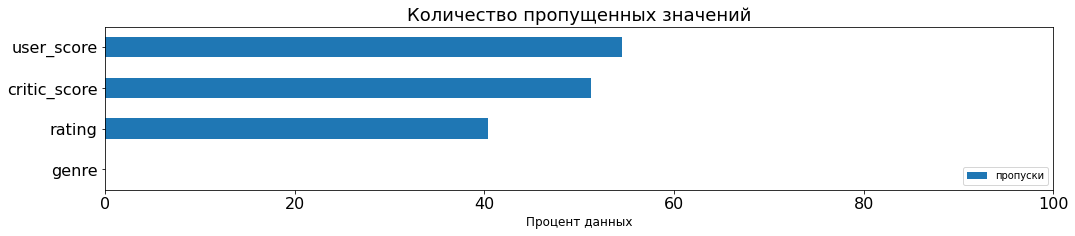

              пропуски
user_score        9024
critic_score      8489
rating            6695
genre                1


In [20]:
show_nan(data)

Имеется довольно большое количество пропусков по столбцам user_score, critic_score и rating, при этом количество пропущенных данных user_score значительно увеличилось после преобразования типа, так как в исходной данных имелись значения `tbd`, которые были исключены из выборки.

In [21]:
print(
    "Всего записей с пропусками в данных:             ",
    len(data.query("user_score.isna() or critic_score.isna() or rating.isna()")),
    "\nиз них:",
    "\nПропущены все значения:                          ",
    len(data.query("user_score.isna() and critic_score.isna() and rating.isna()")),
    "\nПропущены только оценки пользователей и критиков:",
    len(data.query("user_score.isna() and critic_score.isna() and not rating.isna()")),
    "\nПропущены только оценки пользователей:           ",
    len(data.query( "user_score.isna() and not critic_score.isna() and not rating.isna()")),
    "\nПропущены только оценки критиков:                ",
    len(data.query( "critic_score.isna() and not rating.isna() and not user_score.isna()")),
    "\nПропущен только рейтинг:                         ",
    len(data.query( "rating.isna() and not critic_score.isna() and not user_score.isna()")),
    "\nПропущены оценки критиков и рейтинг:             ",
    len(data.query("critic_score.isna() and rating.isna() and not user_score.isna()")),
    "\nПропущены оценки пользователей и рейтинг:        ",
    len(data.query("user_score.isna() and rating.isna() and not critic_score.isna()")),
)

Всего записей с пропусками в данных:              9663 
из них: 
Пропущены все значения:                           6598 
Пропущены только оценки пользователей и критиков: 1320 
Пропущены только оценки пользователей:            1093 
Пропущены только оценки критиков:                 555 
Пропущен только рейтинг:                          68 
Пропущены оценки критиков и рейтинг:              16 
Пропущены оценки пользователей и рейтинг:         13


Больше всего пропусков по всем значениям - 6598, при этом имеются отдельные пропуски по каждому значению отдельно и различные пропуски в парах значений без явно видимой зависимости. Здесь также сложно явно определить почему имеются пропуски в даных. Вероятнее всего не по всем играм были оценки, особенно по редким и устаревшим платформам, а также по совсем свежим, в частности о неготовности рейтингов по пользователям нам может говорить значение `tbd` в оценках пользователей. Также ESRB возможно не по всем играм или платформам присваивает свои рейтинги. 

Заполнять пропущенные значения не имеет смысла, так как все оценки носят субъективный характер, что невозможно рассчитать какими-то формулами, можно лишь спрогнозировать на большом количестве параметров, которых нет в исходных данных.

### Суммарный объем продаж

In [22]:
data["sales"] = data["na_sales"] + data["eu_sales"] + data["jp_sales"] + data["other_sales"]
data["sales"].describe()

count    16561.000000
mean         0.535513
std          1.554556
min          0.000000
25%          0.060000
50%          0.170000
75%          0.470000
max         82.540000
Name: sales, dtype: float64

Произведен рассчет суммарного объема продаж для всех игр в выборке. Половина значений лежит в пределах от 0.06 до 0.047 миллиона штук, медиана 0.17 миллиона штук. Средняя - 0.54 миллиона, что говорит о наличии очень больших выбросов на максимальных значениях, чему соответствует максимальное значение - 82.54 миллиона штук.

### Промежуточные выводы

Проведена подготовка данных:
- Названия столбцов приведены к нижнему регистру для удобства дальнейшей работы;
- Преобразован тип данных параметра year_of_release к целочисленному типу для большего визуального удобства; 
- Параметр user_score преобразован из строкового в числовой для возможности дальнейшей работы с ним. Значение `tbd` по этому параметру интерпретировано как to be determined (будет определено), вследствие чего было исключено из выборки;
- Найдено пропущенное значение в наименовании и жанре, значения продаж сохранены, значение жанра решено не заполнять;
- Обработаны неявные дубликаты по имени и жанру игры, значения в дубликатах просуммированы чтобы не потерять значения по продажам, дублирующиеся значения исключены из выборки;
- Пропуски по годам заполнены аналогичными значениями из других платформ, а в случаи их отсутствия - такие записи удалены. Таких пропусков немного и они не должны внести существенные изменения в выборку;
- Пропуски по оценкам и рейтинге не заполнялись в виду высокой субъективной составляющей, которую невозможно рассчитать на имеющихся данных;
- Причину пропусков точно установить невозможно, имеются предположения, что не по всем параметрам вообще имеются значения в исходных данных, в частности, таких как оценки и рейтинги, которые возможно не для всех игр проводились. Также не исключается вероятность человеческого фактора и ошибок при выгрузке или передаче данных;
- Рассчитаны суммарные продажи по всем регионам, которые записаны в столбец `sales`.

## Исследовательский анализ данных

### Объемы производства игр

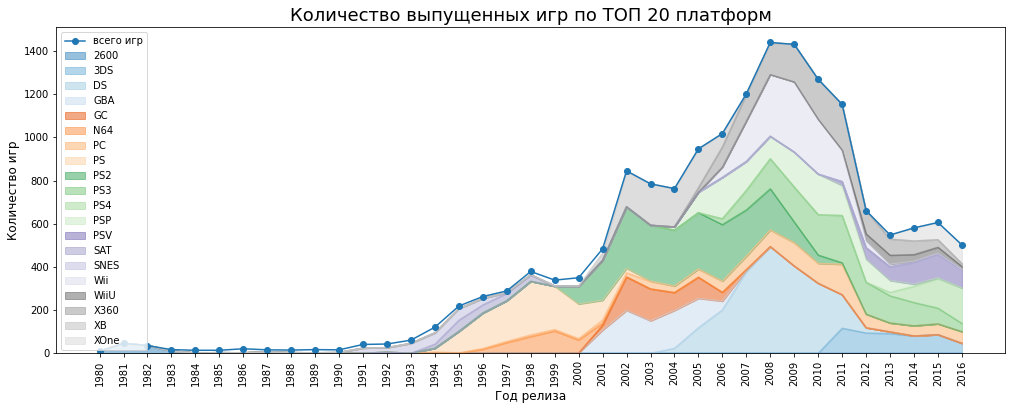

Общее количество платформ: 31
ТОП 5 платформ по количеству игр:
PS2     2140
DS      2129
PS3     1317
Wii     1301
X360    1250
Name: platform, dtype: int64


In [23]:
data.query(
    "platform.isin(@data.platform.value_counts().head(20).index)"
).pivot_table(
    values="sales", index="year_of_release",
    columns="platform", aggfunc="count"
).plot(
    kind="area", figsize=(17, 6), rot=90, alpha=0.5,
    colormap="tab20c", 
)

data.groupby("year_of_release")["sales"].count().rename("всего игр").plot(
    style="-o", xticks=range(1980, 2017), rot=90
)

plt.title("Количество выпущенных игр по ТОП 20 платформ" , size=18)
plt.xlabel("Год релиза", size=12)
plt.ylabel("Количество игр", size=12)
plt.legend(loc="upper left")

plt.show()

print(f"Общее количество платформ: {len(data.platform.unique())}")
print(
    "ТОП 5 платформ по количеству игр:\n",
    data.platform.value_counts().head(5), sep=""
)

Заметно, что с 1980 по 1990 годы выпускалось довольно малое количество игр. С 1991 начался небольшой рост, который ускорился с 1994 по 1998 годы со снижением в 1999-2000 (пузырь доткомов) и дальнейшим ростом до 2008 года (финансовый кризис). Самый резкий рост был в 2002 году с последующей коррекцией в 2003-2004 годах. С 2009 года наблюдается существенное снижение с резким падением в 2011-2012 годах и небольшой коррекцией с 2013 по 2015 годы. По 2016 году показатели не полные, соответственно количество игр может вырасти. До конца года прогнозируется рост игровой индустрии по сравнению с 2015 годом.

Платформы с течением времени появляются и исчезают, некоторые платформы живут дольше, другие меньше - в основном от 7 до 15 лет, а в среднем около 10-ти лет. Одна из первых массовых платформ - PS, которая начала свой путь с 1993-го года и просуществовала до 2003 года, которую начала вытеснять платформа N64  с 1995 года и далее платформа PS2 c 1999 года. С 2000-го года заметен очень большой рост количества игр за счет 2-х новых платформ, которые исчезли к 2007-му году. Рост других платформ начался с 2003-2004-х годов, которые исчезли к 2013-2014 годам. В целом наблюдается выпуск новых платформ в 3-летний период. Есть и долгожители - платформа PC, которая существует с 1993 года, заметный рост по количеству игр относительно других платформ начался с 2002 года и усилился после 2008-го. Всего в выборке присутствует 31 платформа, самое большое количество игр приходится на PS2, далее идут DS, PS3, Wii и X360 - они все попали в пик 2008 года.

На 2017 год большие ожидания в области виртуальной реальности, так как VR технологии активно начали свою экспансию в 2016-м году, пользователи ждут выхода игр с большим бюджетом в VR. Также высокие ожидания от технологий дополненной реальности после успеха Pokemon Go. Несомненно большой интерес представляет рынок мобильных игр. Самой ожидаемой консолью 2017 года является Nintendo Switch.

### Продажи игр

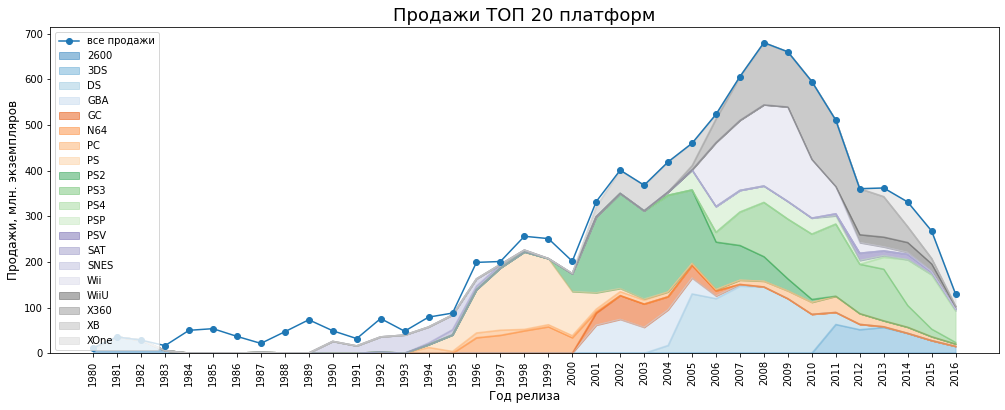

ТОП 5 платформ по продажам игр:
platform
PS2     1247.16
X360     966.61
PS3      935.00
Wii      903.31
DS       804.28
Name: sales, dtype: float64


In [24]:
data.query(
    "platform.isin(@data.platform.value_counts().head(20).index)"
).pivot_table(
    values="sales", index="year_of_release",
    columns="platform", aggfunc="sum"
).plot(
    kind="area", figsize=(17, 6), rot=90, alpha=0.5,
    colormap="tab20c", 
)

data.groupby("year_of_release")["sales"].sum().rename("все продажи").plot(
    style="-o", xticks=range(1980, 2017), rot=90
)

plt.title("Продажи ТОП 20 платформ" , size=18)
plt.xlabel("Год релиза", size=12)
plt.ylabel("Продажи, млн. экземпляров", size=12)
plt.legend(loc="upper left")

plt.show()

print(
    "ТОП 5 платформ по продажам игр:\n",
    data.groupby("platform").sales.sum().sort_values(ascending=False).head(5), sep=""
)

Динамика продаж до 1990 года более разнонаправлена и не сильно зависит от количества выпускаемых игр. Дальнейший рост в целом корелирует с количеством выпускаемых игр. С 2008 года динамика негативная - постоянное снижение с небольшим отском только в 2013 году. Снижение за последние 3 года можно частично списать на то, что продажи игр в последние годы еще не завершены, некоторые платформы на подъеме, другие еще не исчезли и продажи продолжаются. Особенно это актуально для 2016 года, где продажи только начались. Однако учитывая, что имеет место рост количества выпущенных игр, падение продаж все таки наблюдается. 

Самой крупной платформой по продажам за все время также является PS2, ниже располагаются X360, PS3, Wii и DS.

Оценим продажи с 2012 года, когда остановилось падение продаж новых игр с 2008-го года и начался рост, а также появились игры для новых платформ XOne и PS4. При этом лучше смотреть на распределение в процентном, а не в количественном соотношении.

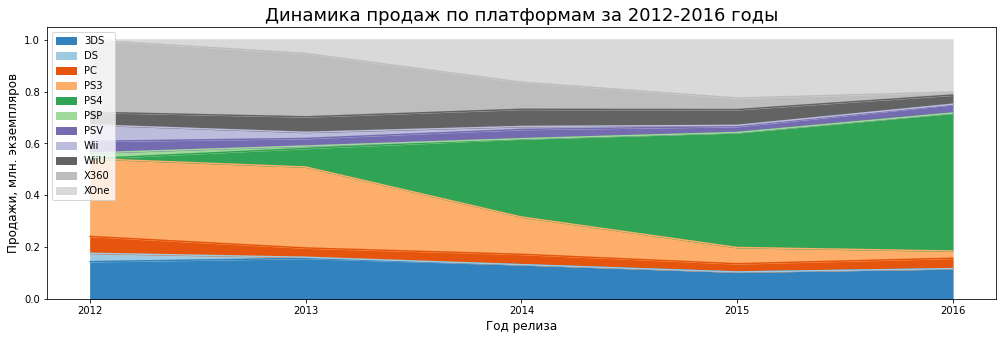

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,14.36,3.24,6.50,30.03,NaN,2.21,4.49,6.36,4.87,27.94,NaN
2013,15.62,0.43,3.59,31.28,7.18,0.93,2.92,2.37,5.98,24.46,5.24
2014,13.20,NaN,4.01,14.41,30.16,0.07,3.59,1.13,6.64,10.48,16.31
2015,10.37,NaN,3.18,6.28,44.37,0.04,2.33,0.43,6.10,4.46,22.44
2016,11.65,NaN,4.04,2.77,53.29,NaN,3.27,0.14,3.54,1.17,20.12


In [25]:
actual_data = data.query("year_of_release >= 2012")

(actual_data.pivot_table(
    values="sales", index="year_of_release",
    columns="platform", aggfunc="sum"
).dropna(axis=1, how="all").T / 
actual_data.groupby("year_of_release")["sales"].sum().to_list()).T.plot(
    kind="area", figsize=(17, 5), 
    colormap="tab20c", xticks=range(2012, 2017)
)
plt.title("Динамика продаж по платформам за 2012-2016 годы" , size=18)
plt.xlabel("Год релиза", size=12)
plt.ylabel("Продажи, млн. экземпляров", size=12)
plt.legend(loc="upper left")
plt.show()

round(actual_data.pivot_table(
    values="sales", index="year_of_release",
    columns="platform", aggfunc="sum"
).dropna(axis=1, how="all").T / 
actual_data.groupby("year_of_release")["sales"].sum().to_list() * 100, 2).T

Платформа DS перестала существовать к 2013-му году и ее для дальнейшего анализа рассматривать не имеет смысла, анализу подлежат 10 платформ. Платформы PSP и Wii судя по показателями уже в самом конце жизненного цикла, доля рынка которых уже очень незначительная и снижается, в частности по PSP в 2016-м году продажи новых продуктов нет. Платформа PSV судя по ее динамике так и не получила достаточной популярности и продолжает снижаться, в отличие от ее предшественника PSP, популярность которой была гораздо выше.

Также можно отметить существенное снижение доли рынка по платформам PS3 и X360 в пользу PS4 и XOne, если по последней рост не такой заметный, то PS4 резко выбилась в явные лидеры рынка с долей в 53.3% к 2016-му году. Но возможно XOne может немного отыграть долю, так как по 2016-му году данные не полные. По платформе 3DS наблюдается слабая отрицательная динамика за рассматриваемый период, как и для платформы WiiU, которая занимает гораздо меньший рынок. Однако как я писал ранее, в 2017 году ожидается следующее поколение платформы - Nintendo Switch, соответствено интерес к данным консолям будет угасать. Рынок игр для PC имеет малую долю и постепенно снижается в пределах 4%.

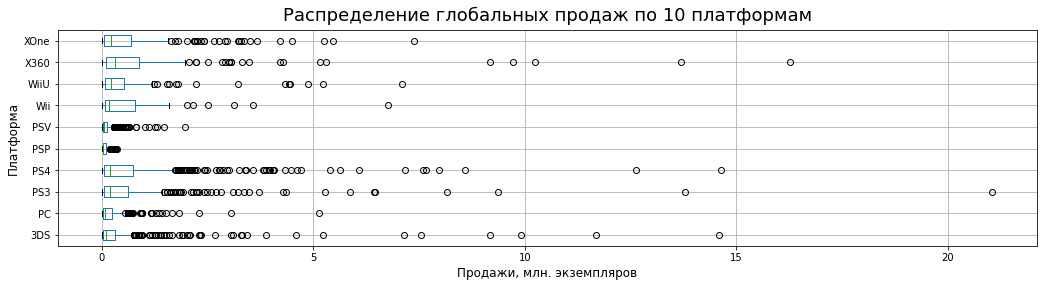

In [26]:
actual_data.query(
    "platform.isin(@data.query('year_of_release > 2013').platform.unique())"
).boxplot(
    column = "sales", by="platform", figsize=(17, 4), vert=False
)
plt.suptitle("Распределение глобальных продаж по 10 платформам" , size=18)
plt.title("")
plt.xlabel("Продажи, млн. экземпляров", size=12)
plt.ylabel("Платформа", size=12)
plt.show()

Распределение глобальных продаж по 10 представленным ранее платформам показывает, что основная масса значений приходится до 2-3 миллионов, а также присутствуют большие отрывов по количеству проданных копий, которые располагаются до 20 миллионов штук, также небольшое количество игр располагается между 20 и 40 миллионами штук по платформам X360, Wii, PS3. Очень большой отрыв имеется по платформе Wii - более 80 млн. штук и в целом больших отрывов по этой платформе больше. Это говорит о том, что для данной платформы выпускались очень популярные игры. Стоит отметить также платформы XOne, XiiU, PSV, PSP и PC где нет игр, продажи которых превышают 10 миллионов штук, особенно низкие показатели для платформы PSV.

Чтобы лучше оценить различия по проджам основной массы игр на различных платформах, ограничим график по верхнему пределу.

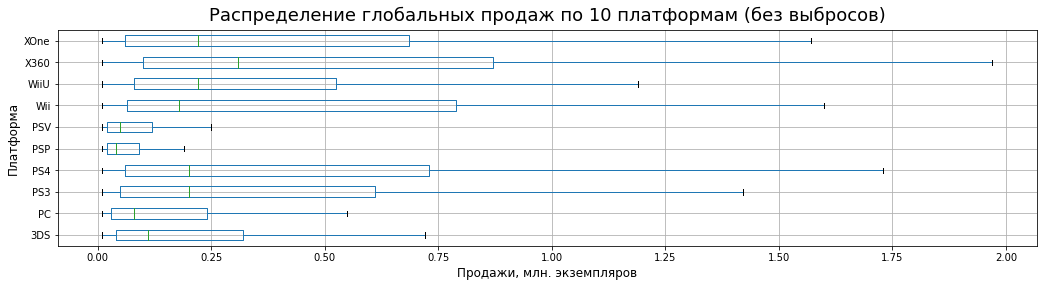

In [27]:
actual_data.query(
    "platform.isin(@data.query('year_of_release > 2013').platform.unique())"
).boxplot(
    column = "sales", by="platform", figsize=(17, 4), vert=False, showfliers=False
)
plt.suptitle("Распределение глобальных продаж по 10 платформам (без выбросов)", size=18)
plt.title("")
plt.xlabel("Продажи, млн. экземпляров", size=12)
plt.ylabel("Платформа", size=12)
plt.show()

При приближении графика к основным значениям можно отметить, что платформы PSV, PSP и PC в среднем имеют более низкие показатели продаж за все время. Основная масса продаж располагается до 2-2.5 миллионов штук. Следующими по продажам можно отметить платформы 3DS, Wii и WiiU, продажи которых заметно выше, но не дотягивают до топовых платформ. Наибольшие продажи по платформам PS3 и X360, приэтом в среднем продажи по X360 немного выше по количеству, чем для PS3. Более новая платформа XOne не догнала продажи предыдущей платформы X360 но достаточно близко. Платформа PS4 за рассматриваемый период обогнала продажи предыдущей платформы PS3. Здесь стоит отметить, что мы исключили пики продаж 2008-го года, и сравниваются только платформы с 2012 года.

Можно сделать вывод, что наиболее предпочтительные платформы - PS4 и XOne, которые активно захватывают рынок и приходят на замену X360 и PS3. Платформы 3DS и WiiU подходят к завершению своего жизненного срока, учитывая планируемый на 2017 год выход платформы Nintendo Switch. Но платформа 3DS занимает достаточный объем рынка, в отличие от WiiU, так что полностью их не нужно списывать, так как платформа Wii показала, что могут быть очень популярные игры для Nintendo. Рынок платформы PC хоть и достаточно малый, но тоже не стоит его исключать.

### Влияние оценок пользователей и критиков на продажи

In [28]:
actual_data.groupby("platform")[["critic_score", 
                                 "user_score"]].count().sort_values(
    "user_score", ascending=False
).head(13)

,critic_score,user_score
platform,,
PS3,214,283
PS4,252,257
X360,172,236
PC,203,211
XOne,169,182
PSV,107,130
3DS,105,115
WiiU,90,100
Wii,6,18


Наибольшее число оценок приходится на PS3. Также достаточно высокое количество оценок для платформы PS4, X360 и PC, существенно более низколе количество оценок имеют игры для платформ XOne, 3DS.

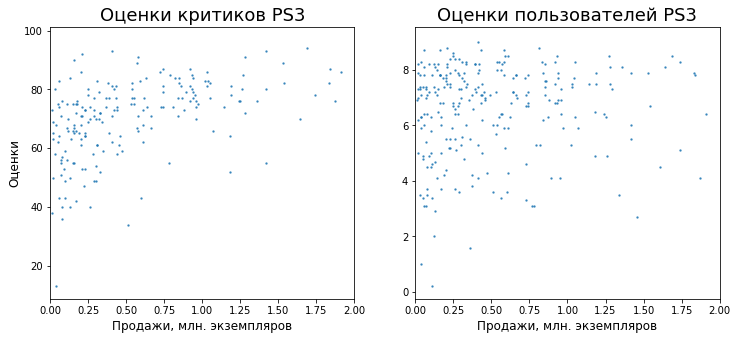

,PS3
sales,1.000000
critic_score,0.334032
user_score,-0.006122


In [29]:
# Довольно сильно завис на данных графиках, так и не разобрался как выводить в одну строку графики с разным соотношением ширины

def show_scatter(df, platform, limit):
  
    fig = plt.figure(figsize=(12, 5))

    fig.add_subplot(121)
    df.query(f"platform == '{platform}'").plot(
        kind="scatter", x="sales", y="critic_score",
        alpha=0.7, s=2, ax=plt.gca()
    )
    plt.xlim(0, limit)
    plt.title(f"Оценки критиков {platform}", size=18)
    plt.xlabel("Продажи, млн. экземпляров", size=12)
    plt.ylabel("Оценки", size=12)

    fig.add_subplot(122)
    df.query(f"platform == '{platform}'").plot(
        kind="scatter", x="sales", y="user_score",
        alpha=0.7, s=2, ax=plt.gca()
    )
    plt.xlim(0, limit)
    plt.title(f"Оценки пользователей {platform}", size=18)
    plt.xlabel("Продажи, млн. экземпляров", size=12)
    plt.ylabel("")
    plt.show()
    display(df.query(f"platform == '{platform}'")[["sales", "critic_score", "user_score"]].corr()["sales"].rename(platform).to_frame())

show_scatter(actual_data,"PS3", 2)

Корреляция между отзывами и продажами положительная, при этом не ярко выраженная. 
- по оценкам критиков более выраженное смещение количества продаж вправо по мере роста оценки. Коэффициент корреляции 0.33, что говорит о недостаточно высокой корреляции. 
- по пользовательским оценкам достаточно равномерное распределение в левом верхнем секторе графика, при этом встречаются гораздо большее количество игр с высокими продажами и более низкими оценками, чем в оценках критиков. Коэффициент корреляции -0.006, что говорит о фактическом отсутствии корреляции.

Можно сделать вывод, что оценки пользователей не коррелируют с количеством продаж, при этом зависимость количества продаж и оценки критиков выше, но тоже не достаточно ярко выраженная, имеются немало игр с высокой оценкой и низкими продажами.

Сравним какие показатели корреляции по платформам PS3 и PC, а также наиболее интересующих нас PS4, XOne и 3DS:

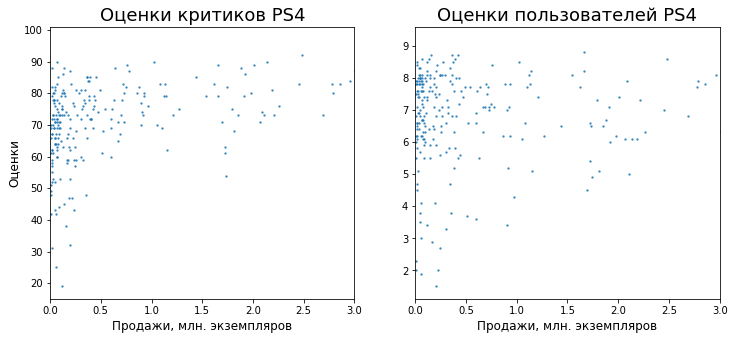

,PS4
sales,1.000000
critic_score,0.406568
user_score,-0.031957


In [30]:
show_scatter(actual_data,"PS4", 3)

По платформе PS4 корреляци чуть более выраженая:
- по оценкам критиков график слегка сместился правее в верхнем секторе. Коэффициент корреляции также увеличился: 0.40;
- по оценкам пользователей график изменился в нижней части, при этом имеются игры с низкими оценками и очень высокими продажами. Коэффициент корреляции также незначительно увеличился: -0.03.

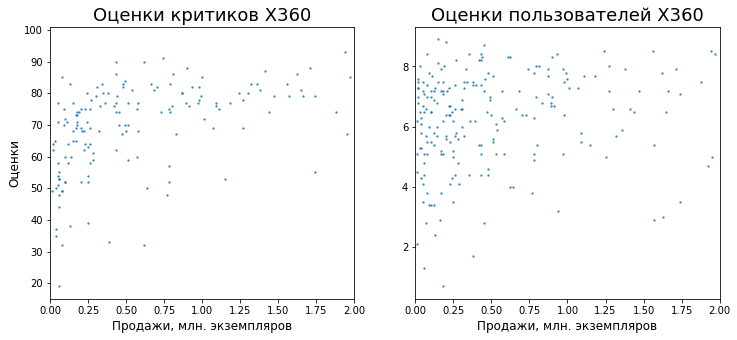

,X360
sales,1.000000
critic_score,0.360266
user_score,0.006315


In [31]:
show_scatter(actual_data, "X360", 2)

По платформе X360 корреляция разнонаправленная:
- по оценкам критиков график ближе к PS3, но оценок горназдо меньше. Коэффициент корреляции: 0.36, чуть меньше чем у PS4;
- по оценкам пользователей график более равномерный, больше игр с высокими продажами с низкой оценкой и наоборот. Коэффициент корреляции практический нулевой: 0.006.

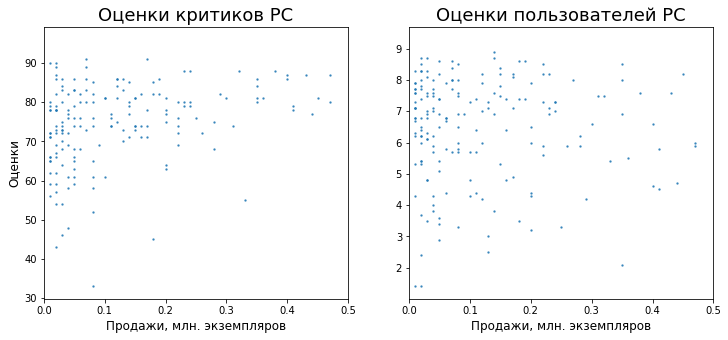

,PC
sales,1.000000
critic_score,0.240570
user_score,-0.120339


In [32]:
show_scatter(actual_data, "PC", 0.5)

По платформе PC корреляция значительно менее выраженая, но более разнонаправленная:
- по оценкам критиков график сильно сместился левее в верхнем секторе, много игр с высокой оценкой и низкими продажами. Коэффициент корреляции по сравнению с предыдущими платформами ниже: 0.24, достаточно низкая корреляция;
- по оценкам пользователей график более равномерный, больше игр с высокими продажами с низкой оценкой. Коэффициент корреляции также значительно уменьшился: -0.12, можно сказать, что имеет место небольшая отрицательная корреляция.

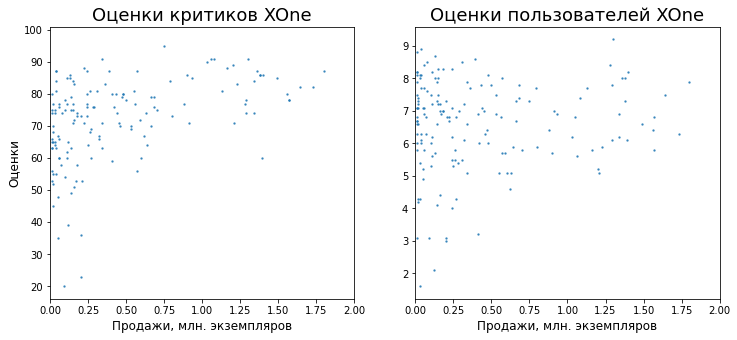

,XOne
sales,1.000000
critic_score,0.416998
user_score,-0.068925


In [33]:
show_scatter(actual_data, "XOne", 2)

По платформе XOne корреляция также разнонаправленная:
- по оценкам критиков график ближе к X360, но оценок горназдо меньше. Коэффициент корреляции: 0.41, самая высокая корреляция;
- по оценкам пользователей график более равномерный, больше игр с высокими продажами с низкой оценкой и наоборот. Коэффициент близкий к PS4: -0.07, корреляция очень низкая и отрицательная.

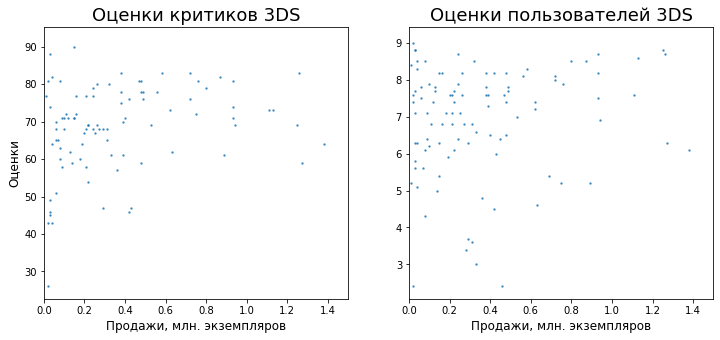

,3DS
sales,1.000000
critic_score,0.320458
user_score,0.198150


In [34]:
show_scatter(actual_data, "3DS", 1.5)

По платформе 3DS корреляция положительная, но довольно мало оценок:
- по оценкам критиков график сдвинут вверх. Коэффициент корреляции: 0.32, немного ниже XOne и PS4;
- по оценкам пользователей график также более равномерный. Коэффициент самый высокий среди рассмотренных: 0.20.

Можно сделать вывод, что в целом корреляция оценки критиков с продажами положительная и прослеживается более явно, более высокие оценки чаще всего у игр с более высокими продажами. По пользователям корреляция достаточно сильно варьируется. Более высокая корреляция у устоявшихся платформ, для новых платформ корреляция практически отсутствует или даже сдвигается в отрицательную сторону.

### Игровые жанры

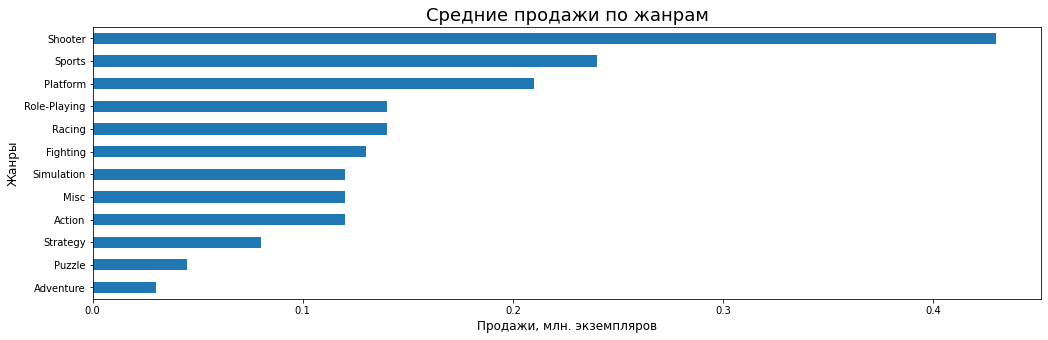

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Shooter,237.0,1.285865,2.245201,0.01,0.13,0.430,1.4700,14.63
Sports,267.0,0.678165,1.137840,0.01,0.08,0.240,0.7450,8.58
Platform,85.0,0.717647,1.364413,0.01,0.09,0.210,0.6600,9.90
Role-Playing,370.0,0.521081,1.315937,0.01,0.06,0.140,0.4075,14.60
Racing,115.0,0.465217,0.888664,0.01,0.05,0.140,0.4200,7.09
Fighting,109.0,0.408165,0.910385,0.01,0.06,0.130,0.3600,7.55
Action,1041.0,0.428828,1.161497,0.01,0.03,0.120,0.4000,21.05
Misc,193.0,0.441865,1.078327,0.01,0.03,0.120,0.3300,9.18
Simulation,80.0,0.439000,1.244500,0.01,0.03,0.120,0.3275,9.17


In [35]:
actual_data.groupby("genre")["sales"].median().sort_values().plot(
    kind="barh", figsize=(17, 5)
)
plt.title("Средние продажи по жанрам", size=18)
plt.xlabel("Продажи, млн. экземпляров", size=12)
plt.ylabel("Жанры", size=12)
plt.show()
actual_data.groupby("genre")["sales"].describe().sort_values("50%", ascending=False)

Самый высокий средний уровень продаж по жанру Shooter. От него с заметным отставанием идут жанры Sports и Platform. Причем если в жанре Sports имеется больше игр, в жанре Platform их значительно меньше, однако могут встречаются игры с большими продажами.

Далее после еще одного заметного снижения средних продаж идут жанры Role-Playing, Racing, Fighting, Simulation, Misc, Action. Здесь также можно отметить жанр Action, который является самым массовым, а также в этом жанре встречаются самые продаваемые игры - 21.05 миллионов проданных копий. Жанр Role-Playing также включает достаточно популярные игры с 14.6 миллионами продаж.

Самые низкие продажи в жанре Adventure, также достаточно низкие в жанрах Puzzle и Strategy.

### Промежуточные выводы
Проведен анализ по количеству выпускаемых игр по годам: 
- отмечено существенное снижение выпуска с 2008 года, с последующим постепенным ростом с 2013 года.
- отмечено, что жизненный цикл платформы составляет порядка 7-15 лет, в среднем около 10 лет;

Проведен анализ по продажам игр по годам:
- отмечено снижение продаж за последние с 2008 года, кроме 2013 года, где был незначительный рост. За последние 3 года это может быть следствием того, что появились новые платформы и продажи игр продолжаются, особенно по 2016-му году;
- определен наиболее актуальный период с 2013 по 2016 годы;
- определены наиболее релевантные для анализа платформы - 3DS, PC, PS3, PS4, PSP, PSV, Wii, WiiU, X360, XOne;
- изучена динамика изменения продаж по платформам за период, заметно сильное падений по платформам PS3, X360, PSP и Wii, что говорит о завершении жизненного цикла таких платформ, также низкий уровень продаж платформ WiiU в целом за весь период существования в отличие от 3DS;
- проведен анализ глобальных продаж по актуальным платформам;
- определены наиболее перспективные платформы по мере убывания: PS4, X360, 3DS, PC, WiiU;
- в части 3DS также нужно ориентироваться на выход платформы Nintendo Switch, который запланирован на 2017 год;

Проведен анализ влияния оценок пользователей и критиков на объем продаж:
- оценки критиков более релевантны объему продаж, так что можно ориентироваться на их оценки;
- отедльно можно отметить платформу PC, где оценки критиков заметно менее релевантны;
- оценки пользователей менее релевантны, особенно для новых платформ, ориентироваться на эти оценки не стоит.

Проведена оценка распределения продаж по игровым жанрам:
- высокий уровень продаж по жанру Shooter. От него с заметным отставанием идут жанры Sports и Platform.
- гораздо более низкие продажи показывают Role-Playing, Racing, Fighting, Simulation, Misc, Action. 
- самые низкие продажи в жанрах Adventure, также достаточно низкие в жанрах Puzzle и Strategy.

Наиболее перспективными можно выделить игры на платформах PS4 и X360, особенно в жанрах Shooter, Sports и Platform.

## Портрет пользователя по регионам

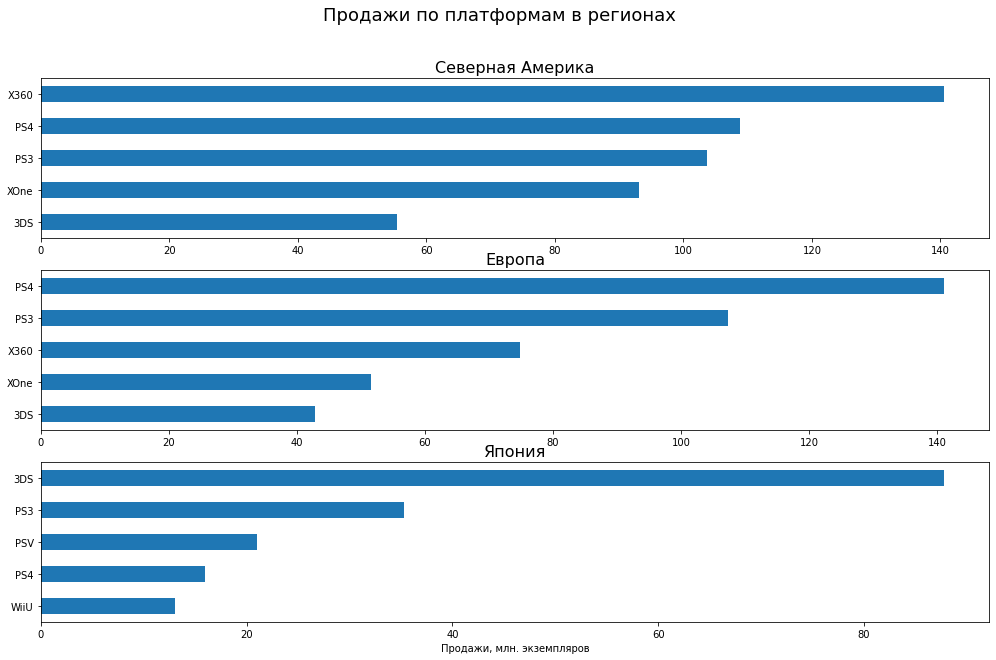

platform,X360,PS4,PS3,XOne,3DS
Северная Америка,24.0,18.0,17.0,16.0,9.0


platform,PS4,PS3,X360,XOne,3DS
Европа,28.0,21.0,15.0,10.0,8.0


platform,3DS,PS3,PSV,PS4,WiiU
Япония,46.0,18.0,11.0,8.0,7.0


In [36]:
def show_top_by(
    df: pd.DataFrame, top: int, by: str, title: str, columns: dict
):
    fig = plt.figure(figsize=(17, 10))
    plt.suptitle(title, size=18)
    item_no = 1
    for col, col_name in columns.items():
        fig.add_subplot(len(columns), 1, item_no)
        df.groupby(by)[col].sum().sort_values(ascending=False).head(top).sort_values().plot(
            kind="barh"
        )
        plt.title(col_name, size=16)
        plt.ylabel("")
        plt.xlabel("")
        item_no += 1
    plt.xlabel("Продажи, млн. экземпляров")
    plt.show()

regions = {"na_sales": "Северная Америка","eu_sales": "Европа", "jp_sales": "Япония"}

show_top_by(actual_data, 5, "platform", "Продажи по платформам в регионах", regions)

def show_top_percent(
    df: pd.DataFrame, top: int, by: str, columns: dict
):
    
    for col, col_name in columns.items():
        display(round(
            df.groupby(by)[col].sum()
            .sort_values(ascending=False).head(top).rename(col_name).to_frame().T / 
            df[col].sum() * 100
        ))

show_top_percent(actual_data, 5, "platform", regions)


1. По Северной Америке за рассматриваемый период наиболее популярной является платформа X360 c 24% от всех продаж, далее идут PS4 (18%), PS3(17%), XOne (16%), 3DS (9%)
2. По Европе гораздо более популярны платформы PS4 (28%) и PS3 (21%), Чуть менее популярны X360 (15%) и XOne(10%), еще меньше 3DS (8%)
3. В Японии рынок сильно сдвинут к другому производителю, почти половину рынка занимает 3DS (46%), далее идут PS3 (18%), PSV (11%), PS4 (8%) и WiiU (7%).

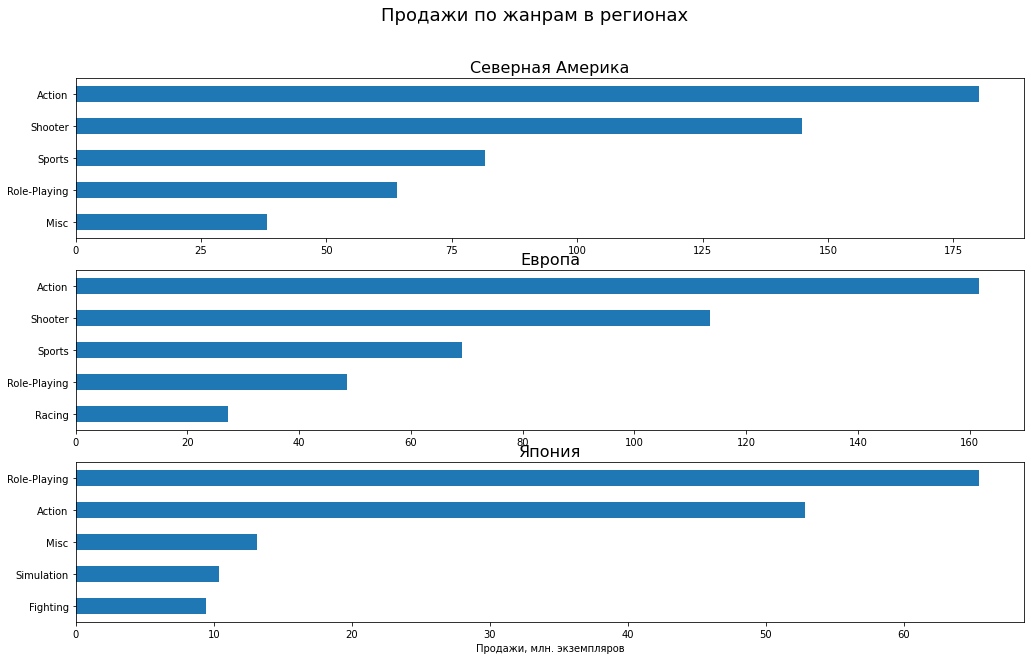

genre,Action,Shooter,Sports,Role-Playing,Misc
na_sales,30.0,24.0,14.0,11.0,6.0


genre,Action,Shooter,Sports,Role-Playing,Racing
eu_sales,32.0,22.0,14.0,10.0,5.0


genre,Role-Playing,Action,Misc,Simulation,Fighting
jp_sales,34.0,27.0,7.0,5.0,5.0


In [37]:
show_top_by(actual_data, 5, "genre", "Продажи по жанрам в регионах", regions)

display(
    round(actual_data.groupby("genre")["na_sales"].sum()
          .sort_values(ascending=False).head(5).to_frame().T / 
          actual_data.na_sales.sum() * 100)
)
display(
    round(actual_data.groupby("genre")["eu_sales"].sum()
          .sort_values(ascending=False).head(5).to_frame().T / 
          actual_data.eu_sales.sum() * 100)
)
display(
    round(actual_data.groupby("genre")["jp_sales"].sum()
          .sort_values(ascending=False).head(5).to_frame().T / 
          actual_data.jp_sales.sum() * 100)
)

1. Наиболее популярные жанры в Северной Америке - Action (30%), Shooter (24%), Sports (14%), Role-Playing (11%), Misc (6%)
2. Наиболее популярные жанры в Европе - Action (32%), Shooter (22%), Sports (14%), Role-Playing (10%), Racing (5%)
3. Наиболее популярные жанры в Японии - Role-Playing (34%), Action (27%), Misc (7%), Simulation (5%), Fighting (5%)

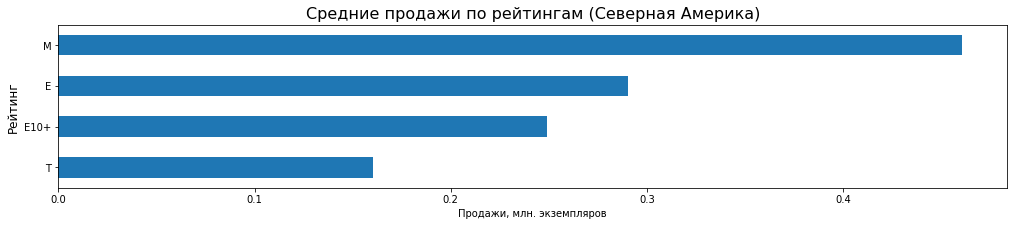

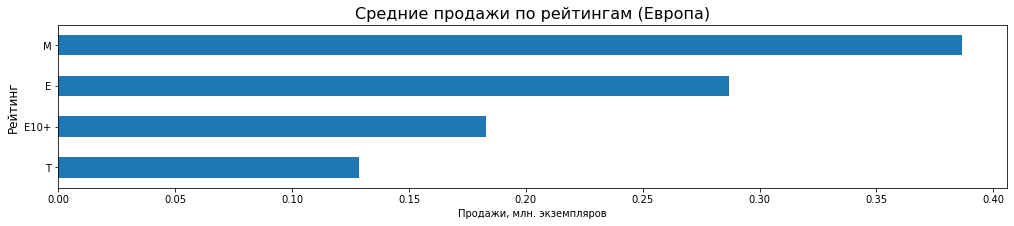

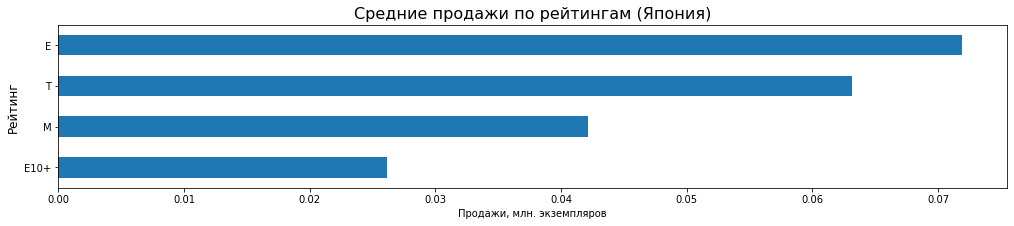

In [38]:
for col, col_name in regions.items():
    actual_data.groupby("rating")[col].mean().sort_values().plot(
    kind="barh", figsize=(17, 3)
    )
    plt.title(f"Средние продажи по рейтингам ({col_name})", size=16)
    plt.ylabel("Рейтинг", size=12)
    plt.xlabel("Продажи, млн. экземпляров")
    plt.show()

1. В Северной Америке и Европе наиболее продаваемые игры с рейтингом M, далее идут E и E10+, наиболее низкие продажи в рейтинге T;
2. Сильно отличается Япония, где наиболее продаваемые игры имеют рейтинг E, далее идут категории T и M, самые низкие продажи в категории E10+

### Промежуточные выводы

Определен портрет пользователя для регионов (NA, EU, JP):
1. Самые популярные платформы (топ-5):
    - в Северной Америке - X360 (24%), PS4 (18%), PS3(17%), XOne (16%), 3DS (9%)
    - в Европе - PS4 (28%), PS3 (21%), X360 (15%), XOne(10%), 3DS (8%)
    - в Японии - 3DS (46%), PS3 (18%), PSV (11%), PS4 (8%) и WiiU (7%).
2. Самые популярные жанры (топ-5):
    - в Северной Америке - Action (30%), Shooter (24%), Sports (14%), Role-Playing (11%), Misc (6%)
    - в Европе - Action (32%), Shooter (22%), Sports (14%), Role-Playing (10%), Racing (5%)
    - в Японии - Role-Playing (34%), Action (27%), Misc (7%), Simulation (5%), Fighting (5%)
3. Влияние рейтинга ESRB на продажи в отдельном регионе:
    - в Северной Америке и Европе выше продажи у игры с рейтингом M, далее идут E и E10+, наиболее низкие продажи в рейтинге T;
    - в Япони выше продажи у игр с рейтингом E, далее идут категории T и M, самые низкие продажи в категории E10+

Рынок Северной америки сдвинут больше к платформам X360 и XOne, доля которых составляет порядка 40%, рынок PS4 и PS3 чуть ниже - 35%, платформа 3DS - 9% рынка. В Европе большую часть рынка занимают платформы PS4 и PS3 в сумме порядка 49%, платформы X360 и XOne - 25%, платформа 3DS - 8%. Очень сильно отличается рынок Японии, где основную массу занимает платформа 3DS - 46%, платформы PS3 и PS4 занимают в сумме 26%, также здесь представлена платформа PSV - 11% рынка и WiiU - 7% рынка.

По жанрам рынки Северной америки и Европы похожи, кроме последнего пункта из ТОП5, где для рынок NA представлен жанром Misc, а рынок EU - Racing. Рынок Японии также сильно отличается от первых двух, где на первую строчку выходит жанр Role-Playing, также в ТОП5 появляются жанры Simulation и Fighting.

По рейтингу ESRB сильно выделяется только рынок Японии, рынки Северной Америки и Европы близки по средним продажам в разрезе рейтингов.

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Необходимо проверить гипотезу, что пользовательские рейтинги Xbox One и PC одинаковые. Это гипотеза равенства двух независимых генеральных совокупностей, так как это различные платформы, могут быть достаточно разные игры, а также различные пользовательские привычки и предпочтения. Оценим количество уникальных значений в выборке:

In [39]:
print(
    "Количество уникальных значений в выборке:",
    len(actual_data.query("platform == 'XOne'").user_score.dropna().unique())
)
print(
    "Количество уникальных значений в выборке:",
    len(actual_data.query("platform == 'PC'").user_score.dropna().unique())
)

Количество уникальных значений в выборке: 51
Количество уникальных значений в выборке: 61


Имеется достаточно значений (более 30), чтобы считать нормальным распределение выборочных средних в соответствии с центральной предельной теоремой. Соответственно выбираем t-тест для независимых совокупностей с равной дисперсией и альтернативной двусторонней гипотезой, по результатам оценим p-значение. Гипотезы для проверки:

**Нулевая гипотеза H0: μ1 = μ2** Истинная средняя генеральной совокупности пользовательских рейтингов платфоры Xbox One равна истинной средней генеральной совокупности пользовательских рейтингов платформы PC.

**Альтернативная гипотеза H1: μ1 ≠ μ2** Истинная средняя генеральной совокупности пользовательских рейтингов платфоры Xbox One не равна истинной средней генеральной совокупности пользовательских рейтингов платформы PC.

Установим самое расспространенное пороговое значение **α = 0.05**

In [40]:
alpha = 0.05
result1 = st.ttest_ind(actual_data.query("platform == 'XOne'").user_score.dropna(), actual_data.query("platform == 'PC'").user_score.dropna())
print(f"p-значение: {result1.pvalue:.2f}")
if (result1.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.63
Не получилось отвергнуть нулевую гипотезу


Значение p-value составляет 0.63, что существенно выше порогового значения, соответственно нулевая гипотеза подтверждается.

**Вывод по гипотезе 1:**
    По представленной выборке подтерждается нулевая гипотеза, что истинная средняя генеральной совокупности пользовательских рейтингов платформы Xbox One равна средней генеральнойсовокупности пользовательских рейтингов платформы PC. Таким образом **нет оснований утверждать, что средние пользовательские рейтинги платформ Xbox One и PC значимо различаются**.

### Средние пользовательские рейтинги жанров Action и Sports разные

Необходимо проверить гипотезу, что пользовательские рейтинги жанров Action и Sports разные. Это также гипотеза равенства двух независимых генеральных совокупностей, так как это различные жанры, игры в жанрах точно разные, а также различные пользовательские привычки и предпочтения. Оценим количество уникальных значений в выборке:

In [41]:
print(
    "Количество уникальных значений в выборке:",
    len(actual_data.query("genre == 'Action'").user_score.dropna().unique())
)
print(
    "Количество уникальных значений в выборке:",
    len(actual_data.query("genre == 'Sports'").user_score.dropna().unique())
)

Количество уникальных значений в выборке: 66
Количество уникальных значений в выборке: 68


Здесь также можно считать нормальным распределение выборочных средних в соответствии с центральной предельной теоремой. Соответственно выбираем аналогичный t-тест для независимых совокупностей с равной дисперсией и альтернативной двусторонней гипотезой, по результатам оценим p-значение. Гипотезы для проверки:

**Нулевая гипотеза H0: μ1 = μ2** Истинная средняя генеральной совокупности пользовательских рейтингов жанра Action равна истинной средней генеральной совокупности пользовательских рейтингов жанра Sports. В случае подтерждения нулевой гипотезы мы будем вынуждены отказаться от выдвинутой гипотезы, что средние пользовательские рейтинги жанров Action и Sports разные, то есть идем от обратного.

**Альтернативная гипотеза H1: μ1 ≠ μ2** Истинная средняя генеральной совокупности пользовательских рейтингов жанра Action равна истинной средней генеральной совокупности пользовательских рейтингов жанра Sports. Если по результатам теста откажемся от нулевой гипотезы, то это подтвердит первоначально выбранную гипотезу.

Оставим пороговое значение **α = 0.05** без изменений

In [42]:
result2 = st.ttest_ind(actual_data.query("genre == 'Action'").user_score.dropna(), actual_data.query("genre == 'Sports'").user_score.dropna())
print(f"p-значение: {result2.pvalue:.27f}")
if (result2.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.000000000000000000000000015
Отвергаем нулевую гипотезу


Значение p-value очень низкое, существенно ниже порогового значения, соответственно нулевая гипотеза опровергается.

**Вывод по гипотезе 2:**
    По представленной выборке отвергается нулевая гипотеза, что истинная средняя генеральной совокупности пользовательских рейтингов (средние пользовательские рейтинги) жанра Action равна средней генеральнойсовокупности пользовательских рейтингов жанра Sports в пользу альтернативной. Соответственно **есть основания утверждать, что средние пользовательские рейтинги жанров Action и Sports отличаются**.

### Промежуточные выводы

Проведена проверка двух гипотез в соответствии со следующими результатами:
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые - **по представленной выборке нет основания утверждать, что пользовательские рейтинги значительно отличаются**;
2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные - **по представленной выборке имеются основания утверждать, что пользовательские рейтинги отличаются**.

## Общий вывод


В рамках исследования данных о продажах игр для подготовки рекомендаций для разработки стратегии на 2017 год для интернет-магазина «Стримчик» проведены следующие работы:

**Получены исходные данные выборки:**
1. Размер выборки составляет - 16715 строк;
2. Имеются пропуски значений по 6 полям: Critic_Score - 8578, Rating - 6766, User_Score - 6701, Year_of_Release - 269, Genre - 2, Name - 2.

**Проведена подготовка данных:**
1. Названия столбцов приведены к нижнему регистру для удобства дальнейшей работы. Преобразованы типы данных параметра year_of_release к целочисленному, user_score преобразован из строкового в числовой для возможности дальнейшей работы с ним (значение `tbd` по этому параметру интерпретировано как to be determined - "будет определено", вследствие чего значения исключены из выборки);
3. Найдено пропущенное значение в наименовании и жанре, значения продаж сохранены, значение жанра решено не заполнять. Обработаны неявные дубликаты по имени и жанру игры, значения в дубликатах просуммированы чтобы не потерять значения по продажам, дублирующиеся значения исключены из выборки;
4. Пропуски по годам заполнены аналогичными значениями из других платформ, а в случае их отсутствия - исключены из выборки. Таких пропусков немного и они не должны внести существенные изменения в выборку;
5. Пропуски по оценкам и рейтинге не заполнялись в виду высокой субъективной составляющей, которую невозможно рассчитать на имеющихся данных. Причину пропусков точно установить невозможно, имеются предположения, что не по всем параметрам вообще имеются значения в исходных данных, в частности, таких как оценки и рейтинги, которые возможно не для всех игр проводились. Также не исключается вероятность человеческого фактора и ошибок при выгрузке или передаче данных;
6. Рассчитаны суммарные продажи по всем регионам, которые записаны в столбец `sales`.

**Проведен исследовательский анализ**
1. Количество выпускаемых игр по годам: 
    - отмечено существенное снижение выпуска с 2008 года, с последующим постепенным ростом с 2013 года.
    - отмечено, что жизненный цикл платформы составляет порядка 7-15 лет, в среднем около 10 лет;

2. Продажи игр по годам:
    - отмечено снижение продаж за последние с 2008 года, кроме 2013 года, где был незначительный рост. За последние 3 года это может быть следствием того, что появились новые платформы и продажи игр продолжаются, особенно по 2016-му году;
    - определен наиболее актуальный период с 2013 по 2016 годы;
    - определены наиболее релевантные для анализа платформы - 3DS, PC, PS3, PS4, PSP, PSV, Wii, WiiU, X360, XOne;
    - изучена динамика изменения продаж по платформам за период, заметно сильное падений по платформам PS3, X360, PSP и Wii, что говорит о завершении жизненного цикла таких платформ, также низкий уровень продаж платформ WiiU в целом за весь период существования в отличие от 3DS;
    - проведен анализ глобальных продаж по актуальным платформам;
    - определены наиболее перспективные платформы по мере убывания: PS4, X360, 3DS, PC, WiiU;
    - в части 3DS, WiiU также нужно ориентироваться на выход платформы Nintendo Switch, который запланирован на 2017 год;

4. Влияние оценок пользователей и критиков на объем продаж:
    - оценки критиков более релевантны объему продаж, так что можно ориентироваться на их оценки;
    - отдельно можно отметить платформу PC, где оценки критиков заметно менее релевантны;
    - оценки пользователей менее релевантны, особенно для новых платформ, ориентироваться на эти оценки не стоит.

5. Распределение продаж по игровым жанрам:
    - высокий уровень продаж по жанру Shooter. От него с заметным отставанием идут жанры Sports и Platform.
    - гораздо более низкие продажи показывают Role-Playing, Racing, Fighting, Simulation, Misc, Action. 
    - самые низкие продажи в жанрах Adventure, также достаточно низкие в жанрах Puzzle и Strategy.

**Определен портрет пользователя по регионам**

1. Самые популярные платформы (топ-5):
    - в Северной Америке - X360 (24%), PS4 (18%), PS3(17%), XOne (16%), 3DS (9%)
    - в Европе - PS4 (28%), PS3 (21%), X360 (15%), XOne(10%), 3DS (8%)
    - в Японии - 3DS (46%), PS3 (18%), PSV (11%), PS4 (8%) и WiiU (7%).
2. Самые популярные жанры (топ-5):
    - в Северной Америке - Action (30%), Shooter (24%), Sports (14%), Role-Playing (11%), Misc (6%)
    - в Европе - Action (32%), Shooter (22%), Sports (14%), Role-Playing (10%), Racing (5%)
    - в Японии - Role-Playing (34%), Action (27%), Misc (7%), Simulation (5%), Fighting (5%)
3. Влияние рейтинга ESRB на продажи в отдельном регионе:
    - в Северной Америке и Европе выше продажи у игры с рейтингом M, далее идут E и E10+, наиболее низкие продажи в рейтинге T;
    - в Япони выше продажи у игр с рейтингом E, далее идут категории T и M, самые низкие продажи в категории E10+

**Проведена проверка двух выдвинутых гипотез**
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые - **по представленной выборке нет основания утверждать, что пользовательские рейтинги значительно отличаются**;
2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные - **по представленной выборке имеются основания утверждать, что пользовательские рейтинги отличаются**

**По результатам проведенного анализа можно сделать следующие выводы:**
1. Платформы PS3 и X360 заканчивают свой жизненный цикл и будут не актуальны в 2017 году, необходимо делать ставку на свежие платформы PS4 и XOne, также в 2017 году ожидается выход платформы Nintendo Switch, соответственно ухудшаются перспективы платформы 3DS и WiiU, так как производители будут переключаться на разработку игр под новую платформу.
2. Наиболее перспективными можно определить следующие платформы: 
    - для рынка Северной Америки - X360 и PS4, с небольшим приоритетом платформы X360. Платформа 3DS по остаточному принципу;
    - для рынка Европы - PS4 и X360, с бóльшим приоритетом PS4. Платформа 3DS также по остаточному принципу;
    - для рынка Японии - 3DS и другие мобильные платформы (PSV, WiiU), PS4. Для данного рынка стоит обратить особое внимание на выход платформы Nintendo Switch.
3. Необходимо больше уделять внимание следующим жанрам: 
    - Shooter, Sports, Role-Playing и Misc по убыванию приоритета;
    - для рынка Европы дополнительно стоит обратить внимание на Racing
    - для рынка Японии первостепенный приоритет у Role-Playing, также стоит обращать внимания на Simulation и Fighting.
4. Не стоит обращать внимание на рейтинги пользователей, рейтинги критиков гораздо лучше коррелируют с объемами продажи, однако не всегда высокие рейтинги залог высоких продаж.
5. Стоит обращать внимание на различия продаж в Японии по рейтингу ESRB:
    - в Северной Америке и Европе продажи игр выше с рейтингами M или E, далее идут E10+ и T 
    - для Японии продажи выше для рейтингов E и T, только дальше идут M, а самые низкие E10+.